In [ ]:
from typing import Dict, List, Optional, TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-8b-8192")


In [5]:
from sentence_transformers import SentenceTransformer
from langchain.docstore.document import Document
from langchain.vectorstores import FAISS
import numpy as np

# Initialize SentenceTransformer model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Mock knowledge base for FAISS
documents = [
    Document(page_content="Billing FAQ: Refunds processed in 5-7 days.", metadata={"category": "Billing"}),
    Document(page_content="Check payment status in account settings.", metadata={"category": "Billing"}),
    Document(page_content="Error 403: Clear cache or reset password.", metadata={"category": "Technical"}),
    Document(page_content="Login issues: Verify credentials or contact support.", metadata={"category": "Technical"}),
    Document(page_content="Security alert: Change password immediately.", metadata={"category": "Security"}),
    Document(page_content="Enable 2FA for account protection.", metadata={"category": "Security"}),
    Document(page_content="General support: Contact us at support@example.com.", metadata={"category": "General"}),
    Document(page_content="FAQs available on our website.", metadata={"category": "General"}),
]

d:\Zikra Info-tech\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
d:\Zikra Info-tech\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\X1 CARBON\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable.

In [6]:
texts = [doc.page_content for doc in documents]
texts

['Billing FAQ: Refunds processed in 5-7 days.',
 'Check payment status in account settings.',
 'Error 403: Clear cache or reset password.',
 'Login issues: Verify credentials or contact support.',
 'Security alert: Change password immediately.',
 'Enable 2FA for account protection.',
 'General support: Contact us at support@example.com.',
 'FAQs available on our website.']

In [7]:
# Generate embeddings using SentenceTransformer
embeddings = model.encode(texts)
embeddings


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(8, 384), dtype=float32)

In [8]:
from langchain.embeddings import HuggingFaceEmbeddings

embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vector_store = FAISS.from_texts(
    texts=[doc.page_content for doc in documents],
    embedding=embedding_function,
    metadatas=[doc.metadata for doc in documents]
)


C:\Users\X1 CARBON\AppData\Local\Temp\ipykernel_11280\3700643233.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [9]:
vector_store

In [10]:
# Define the state
class TicketState(TypedDict):
    ticket: Dict[str, str]  # {subject, description}
    category: str
    context: List[str]
    draft: str
    review_feedback: str
    retry_count: int
    final_response: Optional[str]

In [11]:
import json

classify_prompt = PromptTemplate(
    input_variables=["subject", "description"],
    template="""You are a customer support classifier. Classify the following support ticket into **one** of the following categories:

- **Billing**: Issues related to payments, refunds, charges, invoices, or subscriptions.
- **Technical**: Bugs, crashes, login errors, performance issues, or software malfunctions.
- **Security**: Account breaches, password reset requests, suspicious activity, or data protection concerns.
- **General**: Questions, feedback, feature inquiries, or anything not fitting the other categories.

Return the classification as a valid JSON object **only**, in this format:
{{"category": "<Billing|Technical|Security|General>"}}

Ticket Subject: {subject}
Ticket Description: {description}

Example:
{{"category": "Technical"}}

Only respond with the JSON object. No explanation."""
)

def classify_ticket(ticket: Dict[str, str]) -> str:

    try:
        prompt = classify_prompt.format(
            subject=ticket["subject"],
            description=ticket["description"]
        )

        response = llm.invoke(
            [
                SystemMessage(content="You are a ticket classification assistant. Respond with a JSON object containing a 'category'."),
                HumanMessage(content=prompt)
            ],
            response_format={"type": "json_object"}
        )

        data = json.loads(response.content)
        category = data.get("category", "General")

        return category if category in {"Billing", "Technical", "Security", "General"} else "General"

    except Exception as e:
        print(f"Classification error: {e}")
        return "General"


In [12]:
def retrieve_context(category: str, ticket: Dict[str, str], feedback: str = "") -> List[str]:

    try:
        query = f"{ticket['subject']} {ticket['description']}"

        if feedback:
            query += f" {feedback}"  # Refine query with feedback

        docs = vector_store.similarity_search(query=query, k=2, filter={"category": category})
        context = [doc.page_content for doc in docs]

        return context if context else ["No relevant context found."]

    except Exception as e:
        print(f"Retrieval error: {str(e)}")
        return ["Retrieval failed."]

In [13]:

draft_prompt = PromptTemplate(
    input_variables=["subject", "description", "context"],
    template="""Generate a professional and polite response for the following support ticket using the provided context. Ensure the response is clear, addresses the issue, and is suitable for customer communication. Mention JSON in the context of structured data to ensure compatibility. Return the response as a plain text string.

Ticket Subject: {subject}
Ticket Description: {description}
Context: {context}

Example response: Dear Customer,\nThank you for reaching out. [Address issue based on context]. Please let us know if you need further assistance.\nBest regards,\nSupport Team"""
)

def generate_draft(ticket: Dict[str, str], context: List[str]) -> str:

    try:
        context_str = "\n".join(context) if context else "No context available."

        prompt = draft_prompt.format(subject=ticket["subject"], description=ticket["description"], context=context_str)
        response = llm.invoke([
            SystemMessage(content="You are a customer support assistant. Generate a professional response as a plain text string."),
            HumanMessage(content=prompt)
        ])

        return response.content.strip()

    except Exception as e:

        print(f"Draft error: {str(e)}")
        return "Failed to generate draft."

In [ ]:
# Updated review prompt to enforce JSON output
review_prompt = PromptTemplate(
    input_variables=["draft", "subject", "description"],
    template="""Review the following draft reply to a support ticket. Check for clarity, professionalism, and relevance. Return a JSON object like:

{{"pass": true, "feedback": "The draft is clear and professional."}}

Ticket Subject: {subject}
Ticket Description: {description}
Draft: {draft}

Only return the JSON. Do not include code formatting or explanation."""
)

def review_draft(draft: str, ticket: Dict[str, str]) -> Dict[str, str]:
    try:
        prompt = review_prompt.format(
            subject=ticket["subject"],
            description=ticket["description"],
            draft=draft
        )

        # act as a reviewer.
        response = llm.invoke([
            SystemMessage("You are a draft review assistant. Respond only with a JSON object containing 'pass' and 'feedback'. No explanations, no markdown."),
            HumanMessage(content=prompt)
        ])

      # Parse the JSON response
        data = json.loads(response.content)

      
        if "pass" in data and "feedback" in data:
            return data
        else:
            raise ValueError("Missing keys in response JSON.")

    except Exception as e:
        print(f"Review error: {str(e)}")
        return {"pass": False, "feedback": f"Review failed due to invalid response format: {str(e)}. Please escalate to human review."}


In [15]:
def log_escalation(state: TicketState):
    """Log failed ticket to CSV for human review."""
    with open("escalation_log.csv", "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            state["ticket"]["subject"],
            state["ticket"]["description"],
            state["category"],
            state["draft"],
            state["review_feedback"]
        ])

# Define LangGraph nodes
def input_node(state: TicketState) -> TicketState:
    print(state)
    return state

def classify_node(state: TicketState) -> TicketState:

    state["category"] = classify_ticket(state["ticket"])
    print("State at classification node ", state)
    return state

def retrieve_node(state: TicketState) -> TicketState:

    state["context"] = retrieve_context(state["category"], state["ticket"], state.get("review_feedback", ""))
    print("State at retrieve node ", state)
    return state

def draft_node(state: TicketState) -> TicketState:

    state["draft"] = generate_draft(state["ticket"], state["context"])
    print("State at draft node ", state)

    return state

def review_node(state: TicketState) -> TicketState:

    review = review_draft(state["draft"], state["ticket"])

    state["review_feedback"] = review["feedback"]

    if review["pass"]:
        state["final_response"] = state["draft"]

    print("State at review node ", state)
    return state

def retry_or_escalate(state: TicketState) -> str:

    print(f"Retry count: {state['retry_count']}")  # Debugging
    if state.get("final_response"):
        print("Ending due to final response")
        return "end"
    if state["retry_count"] >= 2:
        print("Escalating to CSV log")
        log_escalation(state)
        return "end"
    state["retry_count"] += 1
    print("Retrying, returning to retrieve")
    return "retrieve"



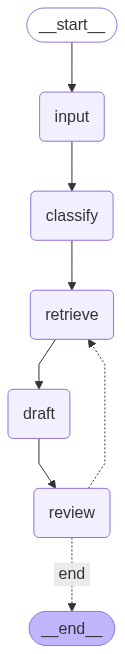

In [16]:

# Build LangGraph workflow
workflow = StateGraph(TicketState)
workflow.add_node("input", input_node)
workflow.add_node("classify", classify_node)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("draft", draft_node)
workflow.add_node("review", review_node)

workflow.set_entry_point("input")
workflow.add_edge("input", "classify")
workflow.add_edge("classify", "retrieve")
workflow.add_edge("retrieve", "draft")
workflow.add_edge("draft", "review")
workflow.add_conditional_edges(
    "review",
    retry_or_escalate,
    {"retrieve": "retrieve", "end": END}
)

# Compile graph with memory
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:

# Example usage
def run_agent(ticket: Dict[str, str]):
    initial_state = TicketState(
        ticket=ticket,
        category="",
        context=[],
        draft="",
        review_feedback="",
        retry_count=0,
        final_response=None
    )
    result = graph.invoke(initial_state, config={"thread_id": "ticket-001", "recursion_limit": 50})
    return result

# Test the agent
if __name__ == "__main__":
    # Create CSV file with headers
    with open("escalation_log.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Subject", "Description", "Category", "Draft", "Feedback"])

    # Test ticket
    test_ticket = {
    "subject": "Refund not received",
    "description": "I canceled my subscription last week but haven’t received a refund yet."
}




    result = run_agent(test_ticket)
    print("Final State:", json.dumps(result, indent=2))
    if result["final_response"]:
        print("Final Response:", result["final_response"])
    else:
        print("Escalated to human review. Check escalation_log.csv")

{'ticket': {'subject': 'Refund not received', 'description': 'I canceled my subscription last week but haven’t received a refund yet.'}, 'category': '', 'context': [], 'draft': '', 'review_feedback': '', 'retry_count': 0, 'final_response': None}
State at classification node  {'ticket': {'subject': 'Refund not received', 'description': 'I canceled my subscription last week but haven’t received a refund yet.'}, 'category': 'Billing', 'context': [], 'draft': '', 'review_feedback': '', 'retry_count': 0, 'final_response': None}
State at retrieve node  {'ticket': {'subject': 'Refund not received', 'description': 'I canceled my subscription last week but haven’t received a refund yet.'}, 'category': 'Billing', 'context': ['Billing FAQ: Refunds processed in 5-7 days.', 'Check payment status in account settings.'], 'draft': '', 'review_feedback': '', 'retry_count': 0, 'final_response': None}
State at draft node  {'ticket': {'subject': 'Refund not received', 'description': 'I canceled my subscri